In [2]:
import json
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
import numpy as np
from numpy import exp
import collections
from scipy import stats
import math
from statistics import stdev, mean
from fractions import Fraction as fr

%matplotlib inline

### Variables

In [3]:
NUM_INTENTS = 10
NLU_NAMES = ['watson', 'luis', 'snips', 'rasa-sklearn', 'rasa-diet']
COLORS = ['lightcoral', 'yellowgreen', 'deepskyblue', 'purple', 'mediumturquoise', 'mediumorchid', 'khaki', 'salmon', 'darkturquoise', 'gold']
VERSION = 6

### Helper functions

In [4]:
def normalize(vector):
    normalized_vector = [v/sum(vector) for v in vector]
    return normalized_vector

In [5]:
def load_json(path):
    with open(path) as json_file:
        data = json.load(json_file)
    return data

In [6]:
def get_nlu_result_file(nlu, version):
    nlu_result_file = "../results/"+ nlu + "_results_v" + str(VERSION) + ".json"
    return nlu_result_file

In [7]:
def get_output_path(nlu_names, version, nlu="", rank=0, level="rank"):
    if level == "rank":
        if len(nlu_names) > 1:
            img_file = "../visualizations/all_ranks/v" + str(version) + "/" + "_".join(nlu_names) + "_rank_" + str(rank) + "_reliability_diagram.pdf"
        else:
            img_file = "../visualizations/"+ nlu_names + "_diagrams/v" + str(version) + "/" + "_".join(nlu_names) + "_rank_" + str(rank) + "_reliability_diagram.pdf"
    else: # level == "model"
        img_file = "../visualizations/all_models/v" + str(version) + "/" + nlu + "_reliability_diagram.pdf"
    return img_file

In [8]:
def get_confidence_score(test, rank=0, nlu="watson", level="rank"):
    """
    the output of this function differs depending on the level.
    On rank level, the output is a single float that represents the confidence score of a rank 
    On model level, the output is a list of floats that includes the confidence scores of all ranks
    """
    if level == "rank":
        predicted_intent_conf = test['intent_ranking'][rank]['confidence'] # rasa
        return predicted_intent_conf 
    
    else: # level == "model"
        predicted_confidences = [rank['confidence'] for rank in test['intent_ranking']]
        return predicted_confidences

In [9]:
def get_accuracy(test, rank=0, nlu="watson", level="rank"):
    """
    the output of this function differs depending on the level.
    On rank level, the output is a single int that represents the instance-level accuracy of a rank
    On model level, the output is a list of ints that includes the instance-level accuracies of all ranks
    """
    correct_intent = test['correct_intent']
    if level == "rank":
        predicted_intent = test['intent_ranking'][rank]['name']
        accuracy = int(correct_intent == predicted_intent)
        return accuracy
    else:
        test_accuracies = []
        test_accuracies = [rank['name'] == correct_intent for rank in test['intent_ranking']]
        return test_accuracies

In [10]:
def show_reliability_plot(fig, ax, diagram_output_file, plot_title, x_axis_desc='Predicted confidences', y_axis_desc='Accuracy in each bin', save=True, line=True):
    # reference line, legends, and axis labels
    if line:
        line = mlines.Line2D([0, 1], [0, 1], color='black') # perfectly-calibrated model
        transform = ax.transAxes 
        line.set_transform(transform)
        ax.add_line(line)
    plt.legend()
    fig.suptitle(plot_title)
    ax.set_xlabel(x_axis_desc)
    ax.set_ylabel(y_axis_desc)
    if save:
        plt.savefig(diagram_output_file)
    plt.show()

In [11]:
def round_up(n, decimals=0):
    multiplier = 10 ** decimals
    return math.ceil(n * multiplier) / multiplier

In [12]:
def get_instances_conf_and_acc(confs, accs, level="rank"):
    """
    the output of this function differs depending on the level.
    On a rank level, predicted_conf and predicted_acc are int values of confs and accs of a given rank
    On a model level, predicted_conf and predicted_acc are lists of confs and accs of all ranks
    """
    bin_size = 0.1
    num_bins = 10
    decimal_count = 2
    bins = {(round(i * bin_size, decimal_count), round((i+1) * bin_size, decimal_count)): [] for i in range(num_bins)}
    bins_instance_acc = {(round(i * bin_size, decimal_count), round((i+1) * bin_size, decimal_count)): [] for i in range(num_bins)}
    for i in range(len(confs)):
        for bbin in bins.keys():
            predicted_conf = confs[i]
            predicted_acc = accs[i]

            if level=='rank':
                for j, conf in enumerate(predicted_conf):
                    if conf> bbin[0] and conf<= bbin[1]:
                        bins[bbin].append(conf)
                        bins_instance_acc[bbin].append(predicted_acc[j])

            else: # level=='model'
                if predicted_conf> bbin[0] and predicted_conf<= bbin[1]:
                    bins[bbin].append(predicted_conf)
                    bins_instance_acc[bbin].append(predicted_acc)
                    break

    return bins, bins_instance_acc

In [13]:
def normalize_test(nlu, test, normalized_scores):
    """
    Updates scores in a test with normalized scores
    Input: test (json object) with non-normalized scores + list of normalized scores 
    Output: new test with normalized scores
    """
    for rank, score in enumerate(normalized_scores):
        test['intent_ranking'][rank]['confidence'] = score
    return test

In [14]:
def normalize_data(nlu, data):
    """ 
    This function normalizes all confidence scores in the json file
    Output: list of json objects (treated as list of dictionaries)
    """
    new_data = []
    for test in data:
        try:
            original_scores = get_confidence_score(test, nlu=nlu, level="model")
            normalized_scores = normalize(original_scores)
        except:
            normalized_scores = [0.1]*10
        if test['text'] != '':
            new_test = normalize_test(nlu, test, normalized_scores)
            new_data.append(new_test)
    return new_data

In [15]:
def remove_empty_preds(data):
    new_data = []
    for test in data:
        if test['text'] != '':
            new_data.append(test)
    return new_data

# Reliability Diagrams

## Rank level

In [17]:
def get_ranks_calibration(ranks, nlu_names=NLU_NAMES, version=VERSION, is_normalized=False):
    """
    This function runs the main loop to measure the calibration through reliability diagrams
    on a rank level.
    Input: 
        - ranks: list of lists, each sub-list contains the ranks that will be considered in a signle reliability diagram
                    example: ranks = [[0], [1], [2], [3], [4, 5, 6, 7, 8, 9]]
        - nlu_names: list of the nlu names.
        - version: int value of the dataset version.
    Output:
        plt.show() the reliability diagrams of all sub-lists of ranks for all nlu_names
    """
    nlus_and_ranks = {}
    for rank_tuple in ranks:
        for rank in rank_tuple:
            for i, nlu in enumerate(nlu_names): 
                # initialize variables
                nlu_result_file = get_nlu_result_file(nlu, version)
                data = remove_empty_preds(load_json(nlu_result_file))
                if is_normalized:
                    data = normalize_data(nlu, data)

                confidences = []
                accuracies = []
                # get bins and corresponding instance-level accuracy
                for test in data:
                    predicted_intent_conf = get_confidence_score(test, rank=rank, nlu=nlu, level="rank")
                    predicted_intent_acc = get_accuracy(test, rank=rank, nlu=nlu, level="rank")

                    confidences.append(predicted_intent_conf)
                    accuracies.append(predicted_intent_acc)
                    
                if nlu not in list(nlus_and_ranks.keys()):
                    nlus_and_ranks[nlu] = {}
                if rank_tuple not in list(nlus_and_ranks[nlu].keys()):
                    nlus_and_ranks[nlu][rank_tuple] = {'confidences' : [], 'accuracies' : []}
                    
                nlus_and_ranks[nlu][rank_tuple]['confidences'].append(confidences)
                nlus_and_ranks[nlu][rank_tuple]['accuracies'].append(accuracies)
                

    for rank_tuple in ranks:
        diagram_output_file = get_output_path(nlu_names, version, rank=", ".join([str(rank+1) for rank in rank_tuple]), level="rank")
        for i, nlu in enumerate(nlu_names): 

            bins, bins_instance_acc = get_instances_conf_and_acc(nlus_and_ranks[nlu][rank_tuple]['confidences'], nlus_and_ranks[nlu][rank_tuple]['accuracies'])

            # get accuracy of each bin
            bins_acc = {}
            for interval, scores in bins.items():
                if scores != []:
                    # get correct predictions
                    acc_scores = bins_instance_acc[interval]
                    acc = sum(acc_scores) / len(scores)
                    bins_acc[interval] = acc
                else:
                    bins_acc[interval] = None

            # create the diagram
            x_values = ["[" + str(inter[0]) + "-" + str(inter[1]) + "]" for inter, scores in bins.items()]
            bins = [inter[1] for inter, scores in bins.items()]
            accs = [acc for inter, acc in bins_acc.items()]

            # line
            if i==0:
                fig, ax = plt.subplots(figsize=(10, 5))
            plt.plot(bins, accs, marker='o', linewidth=1, label=nlu, color=COLORS[i])
            plt.xticks(bins, x_values)

        plot_title = '{} (rank: {}): Confidence vs Accuracy'.format(" & ".join(NLU_NAMES), ", ".join([str(rank+1) for rank in rank_tuple]))
        show_reliability_plot(fig, ax, diagram_output_file, plot_title, x_axis_desc='Predicted confidences', y_axis_desc='Accuracy in each bin', save=False)

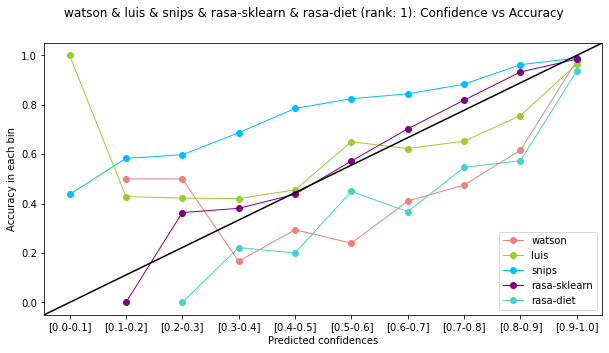

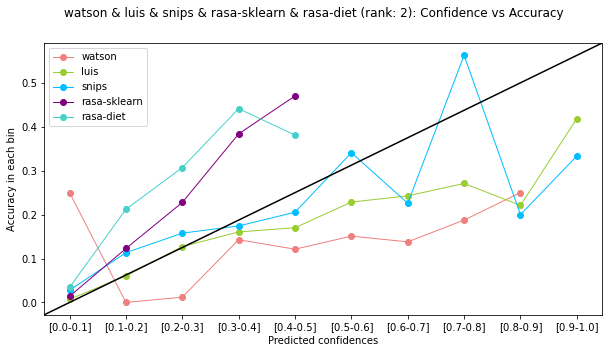

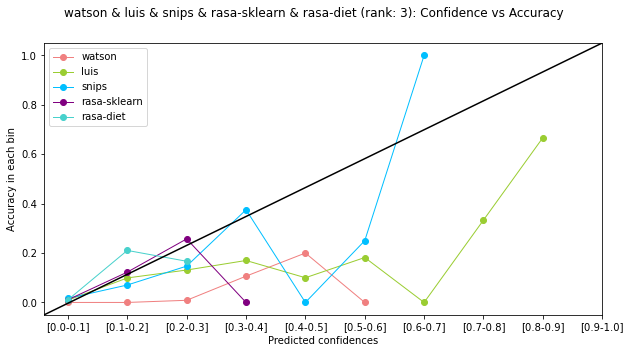

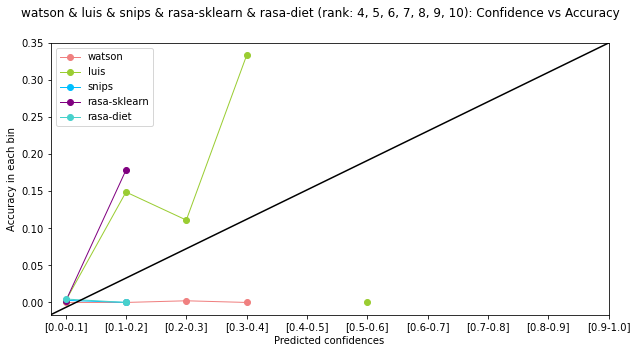

In [18]:
ranks = [(0,), (1,), (2,), (3, 4, 5, 6, 7, 8, 9)]
get_ranks_calibration(ranks)

## Model level

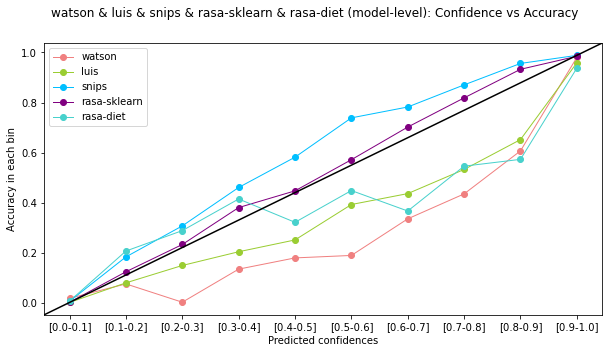

In [19]:
for i, nlu in enumerate(NLU_NAMES): 
    diagram_output_file = get_output_path(NLU_NAMES, VERSION, nlu=nlu, level="model")
    # initialize variables
    nlu_result_file = get_nlu_result_file(nlu, VERSION)
    data = remove_empty_preds(load_json(nlu_result_file))
    # uncomment if you want to use normalized data 
#     data = normalize_data(nlu, data)

    # get bins and corresponding instance-level accuracy
    confidences = []
    accuracies = []
    for test in data:
        
        predicted_intent_conf = get_confidence_score(test, nlu=nlu, level="model")
        predicted_intent_acc = get_accuracy(test, nlu=nlu, level="model")
        confidences.extend(predicted_intent_conf)
        accuracies.extend(predicted_intent_acc)
        
    bins, bins_instance_acc = get_instances_conf_and_acc(confidences, accuracies, level="model")

    # get accuracy of each bin
    bins_acc = {}
    sds = []
    for interval, scores in bins.items():
        if scores != []:
            # get correct predictions
            acc_scores = bins_instance_acc[interval]
            sd = stdev(acc_scores)
            sds.append(sd)
            acc = sum(acc_scores) / len(scores)
            bins_acc[interval] = acc
        else:
            bins_acc[interval] = None

    # create the diagram
    bins_sizes = [len(scores) for inter, scores in bins.items()]
#     print(bins_sizes)
    bins = [inter[0] for inter, scores in bins.items()]
    accuracies = [acc for inter, acc in bins_acc.items()]

    # line
    if i==0:
        fig, ax = plt.subplots(figsize=(10, 5))
#     plt.errorbar(bins, accuracies, fmt='o', yerr=sds, ls='-', capsize=10, label=nlu, color=COLORS[i])
    plt.plot(bins, accuracies, marker='o', linewidth=1, label=nlu, color=COLORS[i])
    xValues = ["[0.0-0.1]","[0.1-0.2]","[0.2-0.3]","[0.3-0.4]","[0.4-0.5]","[0.5-0.6]","[0.6-0.7]","[0.7-0.8]","[0.8-0.9]","[0.9-1.0]"]
    plt.xticks(bins, xValues)
    
plot_title = '{} (model-level): Confidence vs Accuracy'.format(" & ".join(NLU_NAMES))
show_reliability_plot(fig, ax, diagram_output_file, plot_title, x_axis_desc='Predicted confidences', y_axis_desc='Accuracy in each bin', save=False)

# Spearman's Correlation Coefficient

## Rank level

In [20]:
all_nlus_correlations = [] 
for rank in range(NUM_INTENTS):
    for i, nlu in enumerate(NLU_NAMES): 
        # load nlu results
        nlu_result_file = get_nlu_result_file(nlu, VERSION)
        data = remove_empty_preds(load_json(nlu_result_file))
        # uncomment if you want to use normalized data 
#         data = normalize_data(nlu, data)
        
        # get confidence scores and [binary] accuracy for a specific nlu rank
        nlu_confidences = []
        nlu_accuracies = []
        for test in data:
            predicted_intent_conf = get_confidence_score(test, rank=rank, nlu=nlu, level="rank")
            
            predicted_intent_acc = get_accuracy(test, rank=rank, nlu=nlu, level="rank")
            nlu_confidences.append(predicted_intent_conf)
            nlu_accuracies.append(predicted_intent_acc)

        
        # perform spearman correlation per nlu rank
        correlation, pvalue = stats.spearmanr(nlu_confidences, nlu_accuracies, nan_policy='omit')
        all_nlus_correlations.append({'nlu' : nlu , 'rank' : (rank+1), 'correlation' : correlation, 'pvalue' : pvalue})

        
all_nlus_correlations

[{'nlu': 'watson',
  'rank': 1,
  'correlation': 0.4910146623028459,
  'pvalue': 1.925294734944622e-296},
 {'nlu': 'luis',
  'rank': 1,
  'correlation': 0.4054277305451802,
  'pvalue': 1.4011808430031446e-193},
 {'nlu': 'snips',
  'rank': 1,
  'correlation': 0.39065461361920106,
  'pvalue': 8.77791809233595e-179},
 {'nlu': 'rasa-sklearn',
  'rank': 1,
  'correlation': 0.43236984590633093,
  'pvalue': 6.475358285561758e-223},
 {'nlu': 'rasa-diet',
  'rank': 1,
  'correlation': 0.41144623048486917,
  'pvalue': 4.926846328106457e-200},
 {'nlu': 'watson',
  'rank': 2,
  'correlation': 0.22190346811852316,
  'pvalue': 7.626175337559307e-56},
 {'nlu': 'luis',
  'rank': 2,
  'correlation': 0.30238611141754485,
  'pvalue': 2.6279958637085128e-104},
 {'nlu': 'snips',
  'rank': 2,
  'correlation': 0.2388413568278185,
  'pvalue': 1.1607091098531116e-64},
 {'nlu': 'rasa-sklearn',
  'rank': 2,
  'correlation': 0.36281942588945787,
  'pvalue': 1.089850697365772e-152},
 {'nlu': 'rasa-diet',
  'rank':

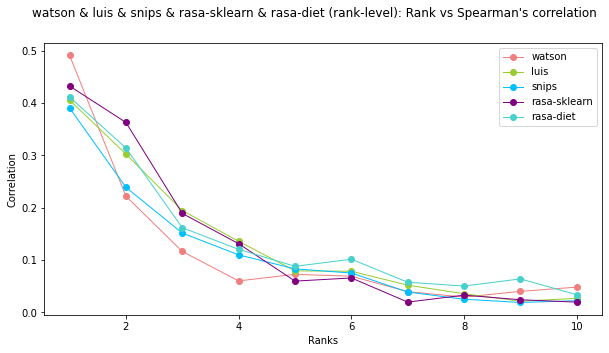

In [21]:
for i, nlu in enumerate(NLU_NAMES):
    nlu_ranks = [nlu_corr['rank'] for nlu_corr in all_nlus_correlations if nlu_corr['nlu']==nlu]
    nlu_correlations = [nlu_corr['correlation'] for nlu_corr in all_nlus_correlations if nlu_corr['nlu']==nlu]
    
    if i==0:
        fig, ax = plt.subplots(figsize=(10, 5))
    plt.plot(nlu_ranks, nlu_correlations, marker='o', linewidth=1, label=nlu, color=COLORS[i])
    
plot_file_name = "../visualizations/correlations/v6_all_ rank_corrs.pdf"
plot_title = '{} (rank-level): Rank vs Spearman\'s correlation'.format(" & ".join(NLU_NAMES))
show_reliability_plot(fig, ax, plot_file_name, plot_title, x_axis_desc='Ranks', y_axis_desc='Correlation', save=False, line=False)

## Model level

In [22]:
all_nlus_correlations = [] 
for i, nlu in enumerate(NLU_NAMES): 
    # load nlu results
    nlu_result_file = get_nlu_result_file(nlu, VERSION)
    data = remove_empty_preds(load_json(nlu_result_file))
    # uncomment if you want to use normalized data 
#     data = normalize_data(nlu, data)

    # get confidence scores and [binary] accuracy for a specific nlu rank
    nlu_confidences = []
    nlu_accuracies = []
    for test in data:
        predicted_confidences = get_confidence_score(test, nlu=nlu, level="model")
        test_accuracies = get_accuracy(test, nlu=nlu, level="model")
        
        nlu_confidences.extend(predicted_confidences)
        nlu_accuracies.extend(test_accuracies)
        
    # perform spearman correlation per nlu rank
    correlation, pvalue = stats.spearmanr(nlu_confidences, nlu_accuracies, nan_policy='omit')
    all_nlus_correlations.append({'nlu' : nlu , 'correlation' : correlation, 'pvalue' : pvalue})
    
all_nlus_correlations

[{'nlu': 'watson', 'correlation': 0.5710203183205977, 'pvalue': 0.0},
 {'nlu': 'luis', 'correlation': 0.4898715790473243, 'pvalue': 0.0},
 {'nlu': 'snips', 'correlation': 0.5066127325166649, 'pvalue': 0.0},
 {'nlu': 'rasa-sklearn', 'correlation': 0.5111358595003317, 'pvalue': 0.0},
 {'nlu': 'rasa-diet', 'correlation': 0.5093299530135772, 'pvalue': 0.0}]

In [23]:
# function to add value labels
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]/1.1, y[i], ha = 'center')

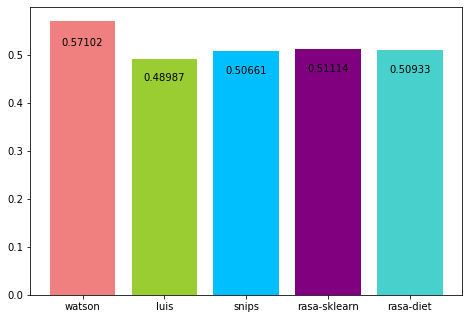

In [24]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
nlu_names = [nlu_corr['nlu'] for nlu_corr in all_nlus_correlations]
nlu_correlations = [round(nlu_corr['correlation'], 5) for nlu_corr in all_nlus_correlations]
ax.bar(nlu_names, nlu_correlations, color=COLORS[:5])
addlabels(nlu_names, nlu_correlations)
plt.show()

# Accuracy and F1-score

In [25]:
from sklearn import metrics

In [26]:
all_nlus_f1_scores = []
all_nlus_accuracies = []
for i, nlu in enumerate(NLU_NAMES): 
    # load nlu results
    nlu_result_file = get_nlu_result_file(nlu, VERSION)
    data = remove_empty_preds(load_json(nlu_result_file))

    predicted_intents = []
    actual_intents = []
    for test in data:
        predicted = test['intent_ranking'][0]['name']
        actual = test['correct_intent']
        
        predicted_intents.append(predicted)
        actual_intents.append(actual)
    

    f1_score = metrics.f1_score(actual_intents, predicted_intents, average='macro')
    accuracy_score = metrics.accuracy_score(actual_intents, predicted_intents)
    
    all_nlus_f1_scores.append({'nlu': nlu, 'f1_score': f1_score})
    all_nlus_accuracies.append({'nlu': nlu, 'accuracy_score': accuracy_score})
    

        
all_nlus_f1_scores

[{'nlu': 'watson', 'f1_score': 0.7635367004745883},
 {'nlu': 'luis', 'f1_score': 0.8116741970226783},
 {'nlu': 'snips', 'f1_score': 0.8955425216212545},
 {'nlu': 'rasa-sklearn', 'f1_score': 0.8747452768599228},
 {'nlu': 'rasa-diet', 'f1_score': 0.8170028091512846}]

In [27]:
all_nlus_accuracies

[{'nlu': 'watson', 'accuracy_score': 0.9295459173284464},
 {'nlu': 'luis', 'accuracy_score': 0.8922167889160554},
 {'nlu': 'snips', 'accuracy_score': 0.8959478721238037},
 {'nlu': 'rasa-sklearn', 'accuracy_score': 0.8763999185501934},
 {'nlu': 'rasa-diet', 'accuracy_score': 0.9016693811074918}]

# All three metrics (Model level)

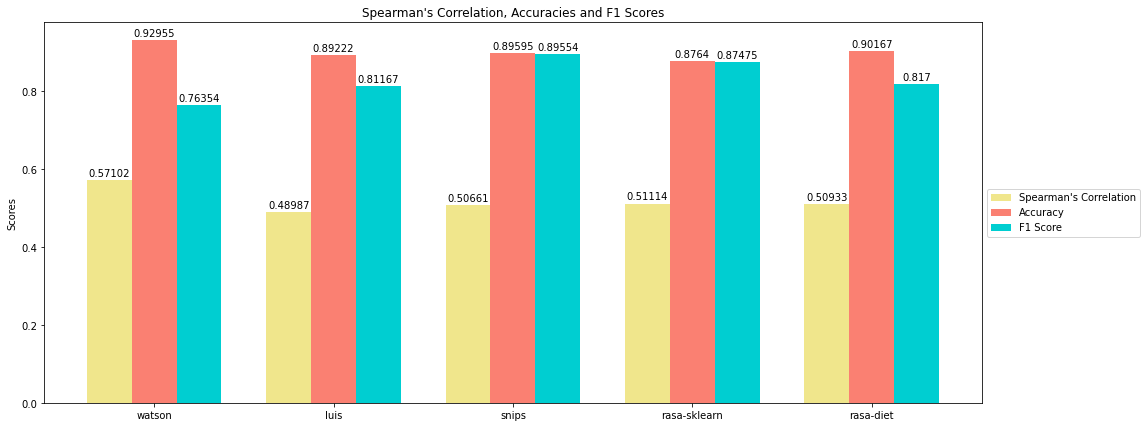

In [114]:
fig, ax = plt.subplots(figsize=(21, 7))

nlu_names = [nlu_corr['nlu'] for nlu_corr in all_nlus_correlations]
nlu_correlations = [round(nlu_corr['correlation'], 5) for nlu_corr in all_nlus_correlations]
nlu_f1_scores = [round(nlu_f1s['f1_score'], 5) for nlu_f1s in all_nlus_f1_scores]
nlu_accuracies = [round(nlu_accs['accuracy_score'], 5) for nlu_accs in all_nlus_accuracies]

width = 0.25  # the width of the bars
x = np.arange(len(nlu_names))  # the label locations

corrs = ax.bar(x - width, nlu_correlations, width, label='Spearman\'s Correlation', align='center',color=COLORS[6])
accs = ax.bar(x , nlu_accuracies, width, label='Accuracy', align='center',color=COLORS[7])
f1s = ax.bar(x + width, nlu_f1_scores, width, label='F1 Score', align='center',color=COLORS[8])



ax.set_ylabel('Scores')
ax.set_title('Spearman\'s Correlation, Accuracies and F1 Scores')
ax.set_xticks(x, nlu_names)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.bar_label(f1s, padding=2)
ax.bar_label(accs, padding=2)
ax.bar_label(corrs, padding=2)

# fig.tight_layout()

plt.show()

In [107]:
# are they correlated? No ~(￣▽￣)~*

In [104]:
correlation1, pvalue1 = stats.spearmanr(nlu_correlations, nlu_f1_scores, nan_policy='omit')
correlation2, pvalue2 = stats.spearmanr(nlu_correlations, nlu_accuracies, nan_policy='omit')

In [105]:
print("Spearman vs F1-score", "\t correlation: ", correlation1, "\t p-value: ", pvalue1)

Spearman vs F1-score 	 correlation:  -0.3 	 p-value:  0.6238376647810728


In [106]:
print("Spearman vs Accuracy", "\t correlation: ", correlation2, "\t p-value: ", pvalue2)

Spearman vs Accuracy 	 correlation:  0.39999999999999997 	 p-value:  0.5046315754686911


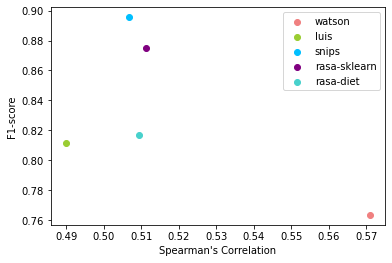

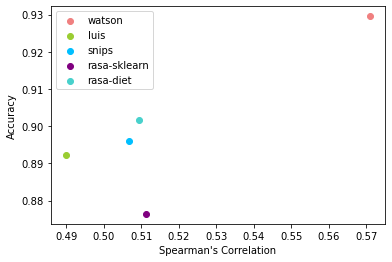

Text(0.5, 1.0, 'Linear graph')

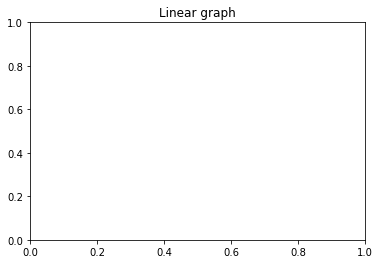

In [31]:
nlu_names = [nlu_corr['nlu'] for nlu_corr in all_nlus_correlations]
nlu_correlations = [round(nlu_corr['correlation'], 5) for nlu_corr in all_nlus_correlations]
nlu_f1_scores = [round(nlu_f1s['f1_score'], 5) for nlu_f1s in all_nlus_f1_scores]
nlu_accuracies = [round(nlu_accs['accuracy_score'], 5) for nlu_accs in all_nlus_accuracies]

for i, nlu in enumerate(nlu_names):
    nlu_correlations = [round(nlu_corr['correlation'], 5) for nlu_corr in all_nlus_correlations if nlu_corr['nlu'] == nlu]
    nlu_f1_scores = [round(nlu_f1s['f1_score'], 5) for nlu_f1s in all_nlus_f1_scores if nlu_f1s['nlu'] == nlu]
    plt.scatter(nlu_correlations, nlu_f1_scores, label=nlu, color=COLORS[i])
plt.xlabel('Spearman\'s Correlation') 
plt.ylabel('F1-score') 
plt.legend()
plt.show()

for i, nlu in enumerate(nlu_names):
    nlu_correlations = [round(nlu_corr['correlation'], 5) for nlu_corr in all_nlus_correlations if nlu_corr['nlu'] == nlu]
    nlu_accuracies = [round(nlu_accs['accuracy_score'], 5) for nlu_accs in all_nlus_accuracies if nlu_accs['nlu'] == nlu]
    plt.scatter(nlu_correlations, nlu_accuracies, label=nlu, color=COLORS[i])
plt.xlabel('Spearman\'s Correlation') 
plt.ylabel('Accuracy') 
plt.legend()
plt.show()